# Visualize Player Highscore pp Distribution
**Contributors:** Victor Lin

**Achievement:** By sampling 50 players at various pp percentiles, stacked pp distribution histograms are generated at each percentile, representing a point-value of the average highscore pp distribution at that percentile. The histograms show, regardless of skill, player highscores are generally evenly distributed for all players, except for peaks at the low pp range & the player's current pp range.

**Requirements:** 

1. MongoDB Collections<br>
1.1 *sql_migration/sql_to_mongo_migration.ipynb* -> osu_user_stats, osu_scores_high
2. Cached Fields<br> 
2.1 *estimate_real_user_pp/user_pp_history.ipynb* -> osu_scores_high.mlpp.est_user_pp, osu_user_stats.mlpp.est_current_pp

In [3]:
import sys
sys.path.append('../..')
from pymongo import UpdateOne
import matplotlib.pyplot as plt
from exploration.config import mongo_inst
from mlpp.data_collection.pp_calculation import fast_pp_hist

In [ ]:
osu_random_db = mongo_inst['osu_random_db']
user_ids_by_pp = list(osu_random_db['osu_user_stats'].find({}, {'mlpp.est_current_pp': 1}).sort('mlpp.est_current_pp'))

## Plotting pp Histograms
Users are selected at different percentiles (based on pp). Each percentiles's user scores are aggregated and plotted as a histogram (right). A histogram of the user's current pp is also plotted (left).

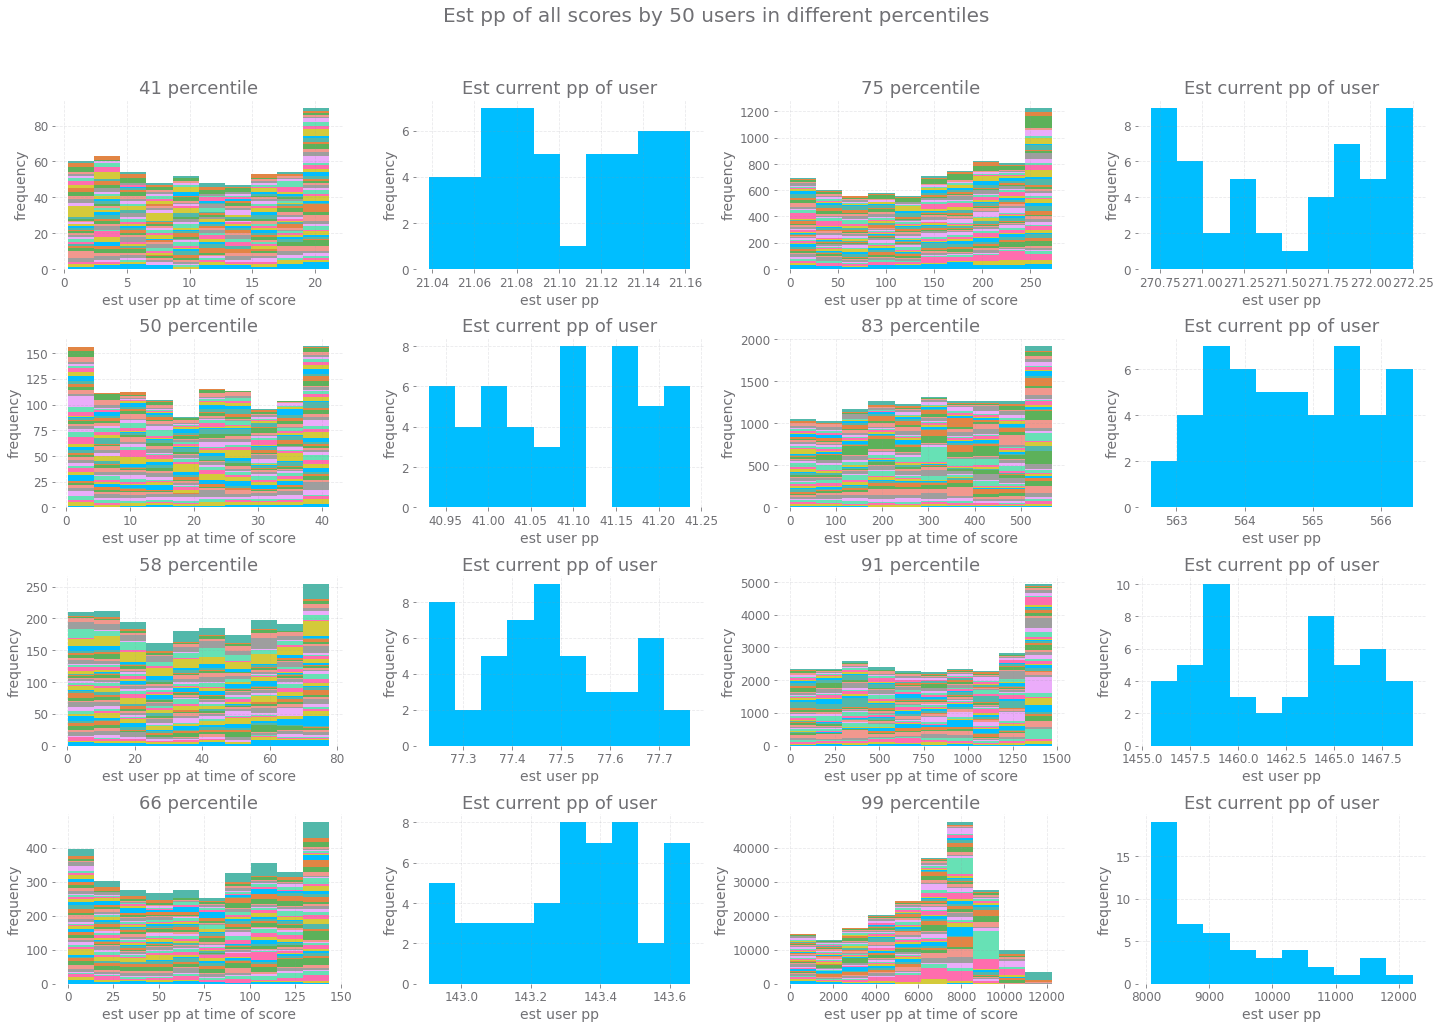

In [5]:
fig, axs = plt.subplots(4, 4)
for i in range(8):
    start_i = 25000 + 5000 * i if i != 7 else -50

    stack_hist = []
    user_pps = []
    for j in range(50):
        user = user_ids_by_pp[start_i + j]
        user_pps.append(user['mlpp']['est_current_pp'])

        user_scores = list(osu_random_db['osu_scores_high'].find({'user_id': user['_id']}))
        stack_hist.append([s['mlpp']['est_user_pp'] for s in user_scores])
    
    row  = i % 4
    col = 2 * (i // 4)
    
    axs[row, col].hist(stack_hist, stacked = True)
    pcnt = int(start_i * 100 / 60000) if i != 7 else 99

    axs[row, col].set_title(f'{pcnt:.0f} percentile')
    axs[row, col].set_xlabel('est user pp at time of score')
    axs[row, col].set_ylabel('frequency')

    axs[row, col + 1].hist(user_pps)

    axs[row, col + 1].set_title('Est current pp of user')
    axs[row, col + 1].set_xlabel('est user pp')
    axs[row, col + 1].set_ylabel('frequency')

fig.set_figheight(15)
fig.set_figwidth(20)
fig.suptitle('Est pp of all scores by 50 users in different percentiles', fontsize = 20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])


## Conclusion

>We will ignore the 99 percentile plot, due to it's wide range of user pp distribution.

>All other percentiles have a pp range of <= 1%, indicating the right histogram can be treated as a point value.

>The score histograms across all percentiles show, on average, the player's highscores are evenly distributed across pp, with a spike of highscores at their current pp.

>This is explained by the fact players are skill capped, and thus will have more highscores at their current skill level.

>Some histograms also show a spike in the low pp range. This is less explainable and will require more exploration.